In [7]:
import os
import zipfile

#Extract the archive/zipfile
zip_ref = zipfile.ZipFile('./cats_and_dogs_filtered.zip', 'r')
zip_ref.extractall("tmp/")
zip_ref.close()

#Assign training and validation set directories 
base_dir = 'tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

#Directory with training cat pics and directory with training dog pictures
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

#Directory with validation cat pics and directory with validation dog pics
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

We're going to place the model creation inside a function so you can easily initialize a new one when you use data augmentation later in the notebook

In [8]:
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop

def create_model():
  '''Creates a CNN with 4 convolutional layers''' 
  model = tf.keras.models.Sequential([
      tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
      tf.keras.layers.MaxPooling2D(2, 2),
      tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(512, activation='relu'),
      tf.keras.layers.Dense(1, activation='sigmoid') 
  ])

  model.compile(loss='binary_crossentropy',
                optimizer=RMSprop(learning_rate = 1e-4),
                metrics=['accuracy'])

  return model



In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#all images will be rescaled by 1/255
train_datagen = ImageDataGenerator(rescale = 1/255)
test_datagen = ImageDataGenerator(rescale = 1/255)

#Flow training images in batches of 20 using train_datagen generator 
train_generator = train_datagen.flow_from_directory(
    train_dir, #this is the source directory for train images
    target_size = (150, 150), #all images will be resized
    batch_size = 20,
    class_mode = 'binary')



#Flow validation images in batches of 20 using test_datagen generator 
validation_generator = test_datagen.flow_from_directory(
    validation_dir, #this is the source directory for test images
    target_size = (150, 150), #all images will be resized
    batch_size = 20,
    class_mode = 'binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [29]:
EPOCHS = 20

#Create new model 
model = create_model()

#train the model
history = model.fit(
    train_generator,
    steps_per_epoch = 100, #2000 images = batch_size *steps
    epochs = EPOCHS, 
    validation_data = validation_generator,
    validation_steps = 50, #1000 images = batch_size * steps
    verbose = 2
)

Epoch 1/20
100/100 - 106s - loss: 0.6879 - accuracy: 0.5385 - val_loss: 0.6708 - val_accuracy: 0.6160 - 106s/epoch - 1s/step
Epoch 2/20
100/100 - 105s - loss: 0.6546 - accuracy: 0.6170 - val_loss: 0.6296 - val_accuracy: 0.6760 - 105s/epoch - 1s/step
Epoch 3/20
100/100 - 105s - loss: 0.6017 - accuracy: 0.6675 - val_loss: 0.5776 - val_accuracy: 0.6990 - 105s/epoch - 1s/step
Epoch 4/20
100/100 - 105s - loss: 0.5632 - accuracy: 0.7120 - val_loss: 0.6040 - val_accuracy: 0.6750 - 105s/epoch - 1s/step
Epoch 5/20
100/100 - 105s - loss: 0.5397 - accuracy: 0.7310 - val_loss: 0.5650 - val_accuracy: 0.7160 - 105s/epoch - 1s/step
Epoch 6/20
100/100 - 106s - loss: 0.5077 - accuracy: 0.7500 - val_loss: 0.5583 - val_accuracy: 0.7110 - 106s/epoch - 1s/step
Epoch 7/20
100/100 - 105s - loss: 0.4864 - accuracy: 0.7605 - val_loss: 0.5409 - val_accuracy: 0.7320 - 105s/epoch - 1s/step
Epoch 8/20
100/100 - 105s - loss: 0.4552 - accuracy: 0.7875 - val_loss: 0.6058 - val_accuracy: 0.6760 - 105s/epoch - 1s/step


You will use a convenience function so that you can easily visualize the loss and accuracy with respect to the training and validation sets

This function will accept a history object which contains the results of the fit() method 

In [10]:
import matplotlib.pyplot as plt

def plot_loss_acc(history):
  '''plots the training and validation loss and accuracy from a history object'''

  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'bo', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Training and validation accuracy')

  plt.figure()

  plt.plot(epochs, loss, 'bo', label='Training Loss')
  plt.plot(epochs, val_loss, 'b', label='Validation Loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

In [ ]:
#plot training results
plot_loss_acc(history)

Data Augmentation

One simple method to avoid overfitting is to augment the images a bit

Take a look at the ImageDataGenerator to see other properties that can be used to augment the image

There are just a few options available:
* `rotation_range` is a value in degrees (0–180) within which to randomly rotate pictures.
* `width_shift` and `height_shift` are ranges (as a fraction of total width or height) within which to randomly translate pictures vertically or horizontally.
* `shear_range` is for randomly applying shearing transformations.
* `zoom_range` is for randomly zooming inside pictures.
* `horizontal_flip` is for randomly flipping half of the images horizontally. This is relevant when there are no assumptions of horizontal assymmetry (e.g. real-world pictures).
* `fill_mode` is the strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift.


Run the next cells to see the impact on the results

The code is similar to the baseline but the definition of `train_datagen` has been updated to use the parameters described above


In [11]:
import tensorflow as tf


#Creating a callback 

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):

    #check accuracy
    accuracy_value = 0.90
    if(logs.get('val_accuracy') > accuracy_value):

      print(f'\nAccuracy is more than {accuracy_value} so cancelling training.')
      self.model.stop_training = True

callbacks = myCallback()

In [19]:
from gc import callbacks

EPOCHS = 20

# creat a new model
model_for_augmentation = create_model()

#this code has changed. Now instead of the ImageGenerator just rescaling the image, we also rotate and do other operations
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale = 1/255)

#Flow training and validation images in batches of 20 using the train_datagen generator and the test_datagen generator respectively 
train_generator = train_datagen.flow_from_directory(
    train_dir, #This is the source directory for the training images
    target_size = (150, 150),
    batch_size = 20,
    class_mode = 'binary'
)

test_generator = test_datagen.flow_from_directory(
    validation_dir, #This is the source directory for the training images
    target_size = (150, 150),
    batch_size = 20,
    class_mode = 'binary'
)


#Train the new model
history_with_augmentation = model_for_augmentation.fit(
    train_generator,
    steps_per_epoch = 100,
    epochs = EPOCHS, 
    validation_data = validation_generator,
    validation_steps = 50,
    verbose = 1,
    callbacks = [callbacks]
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/20
100/100 [==============================] - 120s 1s/step - loss: 0.6928 - accuracy: 0.5275 - val_loss: 0.6817 - val_accuracy: 0.5010
Epoch 2/20
100/100 [==============================] - 118s 1s/step - loss: 0.6801 - accuracy: 0.5615 - val_loss: 0.6501 - val_accuracy: 0.6200
Epoch 3/20
100/100 [==============================] - 117s 1s/step - loss: 0.6683 - accuracy: 0.5885 - val_loss: 0.6486 - val_accuracy: 0.6160
Epoch 4/20
100/100 [==============================] - 118s 1s/step - loss: 0.6378 - accuracy: 0.6375 - val_loss: 0.6349 - val_accuracy: 0.6630
Epoch 5/20
100/100 [==============================] - 118s 1s/step - loss: 0.6269 - accuracy: 0.6430 - val_loss: 0.5864 - val_accuracy: 0.6880
Epoch 6/20
100/100 [==============================] - 117s 1s/step - loss: 0.6131 - accuracy: 0.6570 - val_loss: 0.5770 - val_accuracy: 0.6910
Epoch 7/20
100/100 [==============================] - 117s

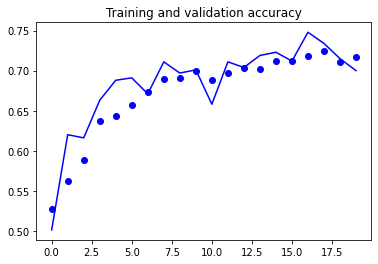

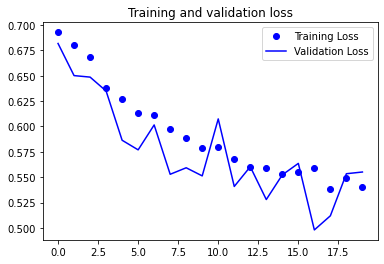

In [20]:
#Plot the results of training with data augmentation 
plot_loss_acc(history_with_augmentation)